# Experiments

## General stuff

### Imports

In [78]:
import yaml
import os
import random

### Load configs

In [79]:
with open("./config.yaml", 'r') as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

print('config...')
print(yaml.dump(config))

with open(os.path.join('vst_config', config['vst'] + '.yaml'), 'r') as stream:
    try:
        config_vst = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
          
print('config_vst...')
print(config_vst)

config...
bufferSize: 512
epsilon: 0.1
fftSize: 2048
hopSize: 512
libPath: ./RenderMan/Builds/LinuxMakefile/build/librenderman.so
midiNote: 72
midiVelocity: 127
noteLength: 1.0
renderLength: 5.0
sampleRate: 22050
vst: podolski

config_vst...
{'vstPath': '/home/seawee1/.vst/u-he/Podolski.64.so', 'init': {0: 0.5, 1: 1.0, 2: 1.0, 3: 1.0, 4: 0.192308, 5: 0.0, 6: 1.0, 7: 0.5, 8: 1.0, 9: 0.0, 10: 0.0, 11: 0.5, 12: 0.5, 13: 0.5, 14: 0.5, 15: 0.5, 16: 0.5, 17: 0.5, 18: 0.5, 19: 0.5, 20: 0.5, 21: 0.5, 22: 0.5, 23: 0.5, 24: 0.5, 25: 0.5, 26: 0.5, 27: 0.0, 28: 0.5, 29: 0.8, 30: 0.5, 31: 0.1, 32: 0.25, 33: 0.192308, 34: 0.0, 35: 0.5, 36: 0.0, 37: 0.5, 38: 0.5, 39: 0.0, 40: 0.5, 41: 0.0, 42: 0.5, 43: 0.0, 44: 0.5, 45: 0.0, 46: 0.0, 47: 1.0, 48: 0.0, 49: 0.0, 50: 0.5, 51: 0.0, 52: 0.5, 53: 0.0, 54: 0.75, 55: 0.5, 56: 0.0, 57: 0.5, 58: 0.3, 59: 0.5, 60: 0.2, 61: 0.5, 62: 0.5, 63: 0.5, 64: 0.0, 65: 0.25, 66: 0.25, 67: 0.0, 68: 0.0, 69: 0.0, 70: 0.142857, 71: 0.0, 72: 0.0, 73: 0.0, 74: 0.0, 75: 0.0, 76

### Symlink librenderman.so to working directory

In [80]:
# Symlink RenderMan library to working directory before import
if not os.path.isfile('librenderman.so'):
    os.symlink(config[libPath], os.path.join('.', 'librenderman.so'))
import librenderman as rm

### Important functions

In [81]:
def create_engine_and_generator(config, config_vst):
    # This will host a VST. It will render the features and audio we need.
    engine = rm.RenderEngine(config['sampleRate'], config['bufferSize'], config['fftSize'])

    # Load the VST into the RenderEngine.
    engine.load_plugin(config_vst['vstPath'])

    # Create a patch generator. We can initialise it to generate the correct
    # patches for a given synth by passing it a RenderEngine which has
    # loaded a instance of the synthesiser. 
    generator = rm.PatchGenerator(engine)

    # We can also get a string of information about the
    # available parameters.
    #print(engine.get_plugin_parameters_description())
    
    return engine, generator

def init_engine(engine, config_vst):
    for index, value in config_vst['init'].items():
        engine.override_plugin_parameter(index, value)
        
def randomize_engine(engine, config_vst):
    for index, value in config_vst['rnd'].items():
        engine.override_plugin_parameter(index, random.uniform(value[0], value[1]))
        
def render_patch(engine, config):
    engine.render_patch(config['midiNote'], config['midiVelocity'], config['noteLength'], config['renderLength'], True)
    audio = engine.get_audio_frames()
    mfccs = engine.get_mfcc_frames()
    return audio, mfccs

### Create and init 

In [82]:
engine, generator = create_engine_and_generator(config, config_vst)
init_engine(engine, config_vst)

## Render stuff

### Render init

In [83]:
#init_engine(engine, config_vst)
audio, mfccs = render_patch(engine, config)
print(mfccs)

print(type(audio))
print(min(audio))
print(max(audio))
from IPython.display import Audio
Audio(audio, rate=config['sampleRate'], autoplay=False)

[]
<class 'list'>
-0.09232762455940247
0.14008569717407227


## Randomize randomized parameters based on vst config

In [84]:
#init_engine(engine, config_vst)
randomize_engine(engine, config_vst)
# Bug? Calling render_patch once makes filter move at beginning of patch
audio, mfccs = render_patch(engine, config)
audio, mfccs = render_patch(engine, config) 
print(min(audio))
print(max(audio))

from IPython.display import Audio
Audio(audio, rate=config['sampleRate'], autoplay=False)

-0.21174921095371246
0.23493358492851257


## MFCC stuff

(40, 217)


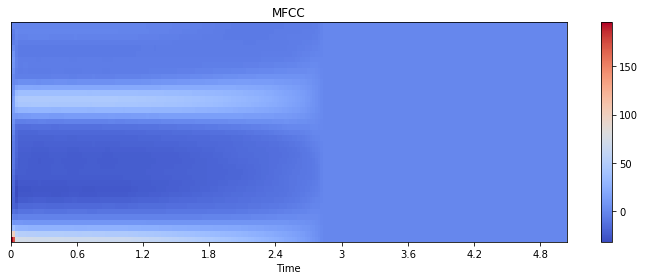

In [85]:
import librosa
import librosa.display
import numpy as np
mfccs = librosa.feature.mfcc(y=np.array(audio), sr=config['sampleRate'], n_mfcc = 40)
print(mfccs.shape)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs[1:], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [86]:
stft = np.abs(librosa.stft(y=np.array(audio), center=False))

102.24173


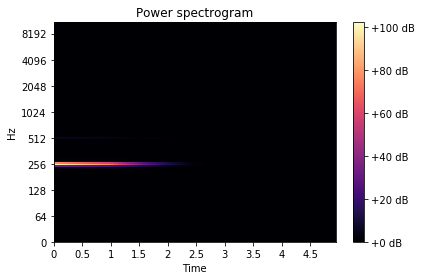

In [87]:
import matplotlib.pyplot as plt
#librosa.display.specshow(librosa.amplitude_to_db(stft, ref=np.max),y_axis='log', x_axis='time')

librosa.display.specshow(stft, y_axis='log', x_axis='time')
print(np.max(stft))
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [88]:
stft_ = np.copy(stft)
stft_ = stft_ - np.min(stft_)
stft_ = stft_ / np.max(stft_)

102.24173


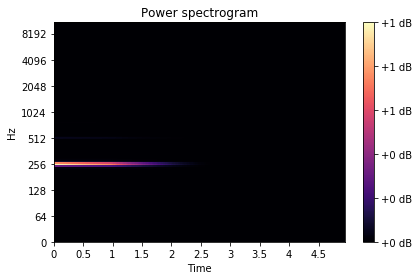

In [89]:
librosa.display.specshow(stft_, y_axis='log', x_axis='time')
print(np.max(stft))
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [90]:
print(stft_.shape)

(1025, 213)


In [91]:
print(44100*5.0)

220500.0


In [92]:
num = 22050 * 5.0
num = num - (num % 2048)
print(num)
num_windows = (num / 2048) * 4.0
print(num_windows)

108544.0
212.0


In [93]:
stft = np.abs(librosa.stft(y=np.array(audio), n_fft=len(audio), center=False))

ValueError: range() arg 3 must not be zero

In [94]:
print(len(audio))

110592


In [99]:
from scipy import fftpack

X = fftpack.fft(x)

(110592,)